# Look into the sea level budget data from Frederikse et al. 2020

In [64]:
import sys
sys.path.append('../code')

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import SeaLevelContrib as slc

In [94]:
def rotate_longitude(ds):
    '''Rotate the longitude of an xarray dataset from [0,360] to [-180,180]'''
    
    if 'lon' in ds.dims:
        lon = 'lon'
    elif 'longitude' in ds.dims:
        lon = 'longitude'
    else:
        print('Longitude not found in dimensions')
        
    ds[lon] = np.where(ds[lon]>180, ds[lon]-360, ds[lon])
    ds = ds.reindex({ lon : np.sort(ds[lon])})
    
    return ds

In [3]:
data_dir = '../data/Frederikse2020/'

In [91]:
tws_ds = xr.open_dataset(f'{data_dir}tws.nc')
tws_ds = rotate_longitude(tws_ds)

In [92]:
tws_ds

<xarray.Dataset>
Dimensions:        (lat: 360, lon: 720, time: 119)
Coordinates:
  * lon            (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat            (lat) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) int16 1900 1901 1902 1903 1904 ... 2015 2016 2017 2018
Data variables:
    tws_rsl_mean   (time, lat, lon) float32 ...
    tws_rsl_sterr  (time, lat, lon) float32 ...
    tws_rad_mean   (time, lat, lon) float32 ...
    tws_rad_sterr  (time, lat, lon) float32 ...
Attributes:
    copyright:  This work is licensed under the Creative Commons Attribution-...

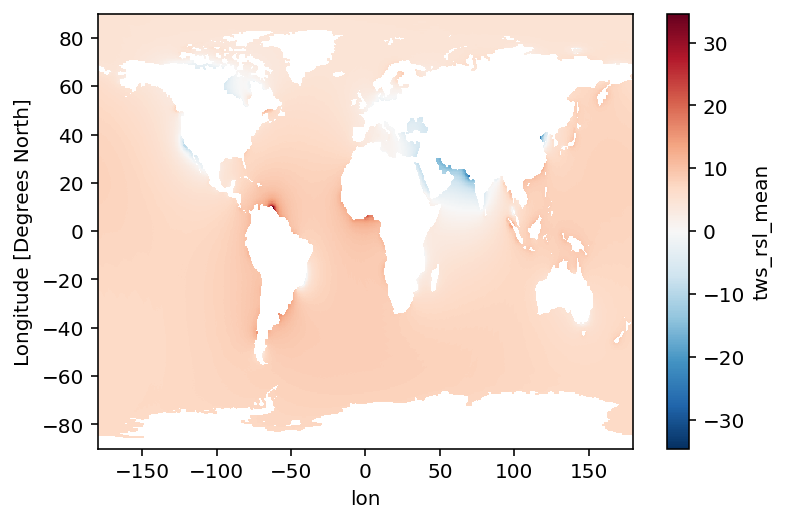

In [93]:
(tws_ds.tws_rsl_mean.sel(time = 2018) - tws_ds.tws_rsl_mean.sel(time = 1979)).plot()

In [136]:
tg_id = [20, 22, 23, 24, 25, 32]

In [163]:
# Build a function
def contrib_frederikse2020(tg_id, var):
    '''
    Read values from Frederikse et al. 2020 budget.
    
    Inputs: 
    List of tide gauges
    Variable (available: tws, AIS, glac, GrIS, steric)
    
    Outputs:
    Dataframe giving the average contribution at the tide gauges
    '''    
    
    data_dir = '../data/Frederikse2020/'
    ds = xr.open_dataset(f'{data_dir}{var}.nc')
    # Fill coastal points to avoid selecting NaN
    sel_da = ds[f'{var}_rsl_mean'].ffill('lon', 3).bfill('lon', 3)
    for i in range(len(tg_id)):
        tg_lat, tg_lon =  slc.tg_lat_lon([tg_id[i]])
        loc_da = sel_da.sel(lon = tg_lon.values, lat = tg_lat.values, 
                            method = 'nearest')
        if i == 0:
            loc_da.name = f'{tg_id[i]}'
            df = loc_da.squeeze().reset_coords(drop=True).to_dataframe()
        else:
            df[f'{tg_id[i]}'] = loc_da.squeeze().values
    
    return df.mean(axis=1)

In [182]:
df = contrib_frederikse2020(tg_id, 'tws')

In [184]:
#df.name = 'tws'
df.to_frame('tws')

,tws
time,
1900,7.325000
1901,8.616667
1902,10.641666
1903,11.300000
1904,9.475000
...,...
2014,-0.491667
2015,1.758333
2016,3.858333


In [38]:
tg_lat, tg_lon =  slc.tg_lat_lon([20])
tws_loc = tws_ds.tws_rsl_mean.ffill('lon', 2).bfill('lon', 2)
tws_loc = tws_loc.sel(lon = tg_lon.values, lat = tg_lat.values, method='nearest')

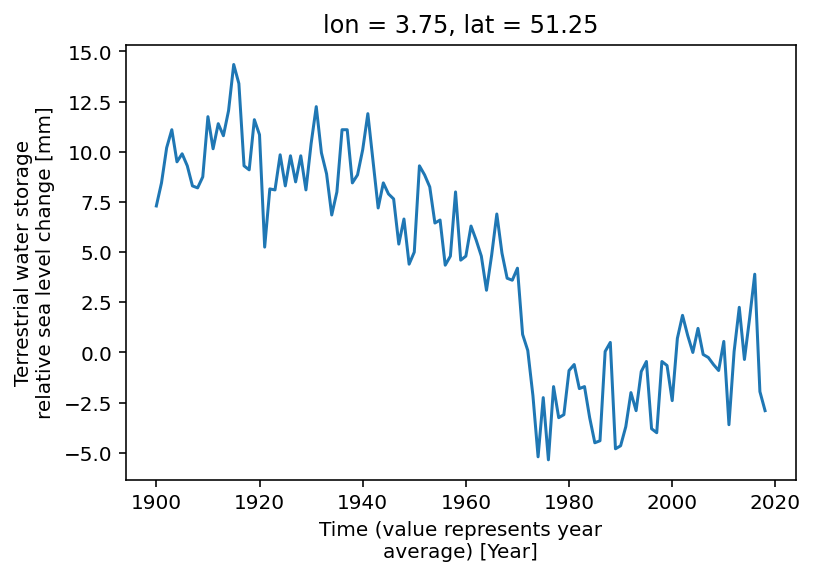

In [40]:
tws_loc.plot() # .sel(time=2018).plot()

In [126]:
tws_loc.squeeze().reset_coords(drop=True).to_dataframe() # .to_dataframe() #.shape # values.shape

,tws_rsl_mean
time,
1900,7.30
1901,8.45
1902,10.20
1903,11.10
1904,9.50
...,...
2014,-0.35
2015,1.70
2016,3.90


In [132]:
tws_loc.values.shape

(119, 1, 1)

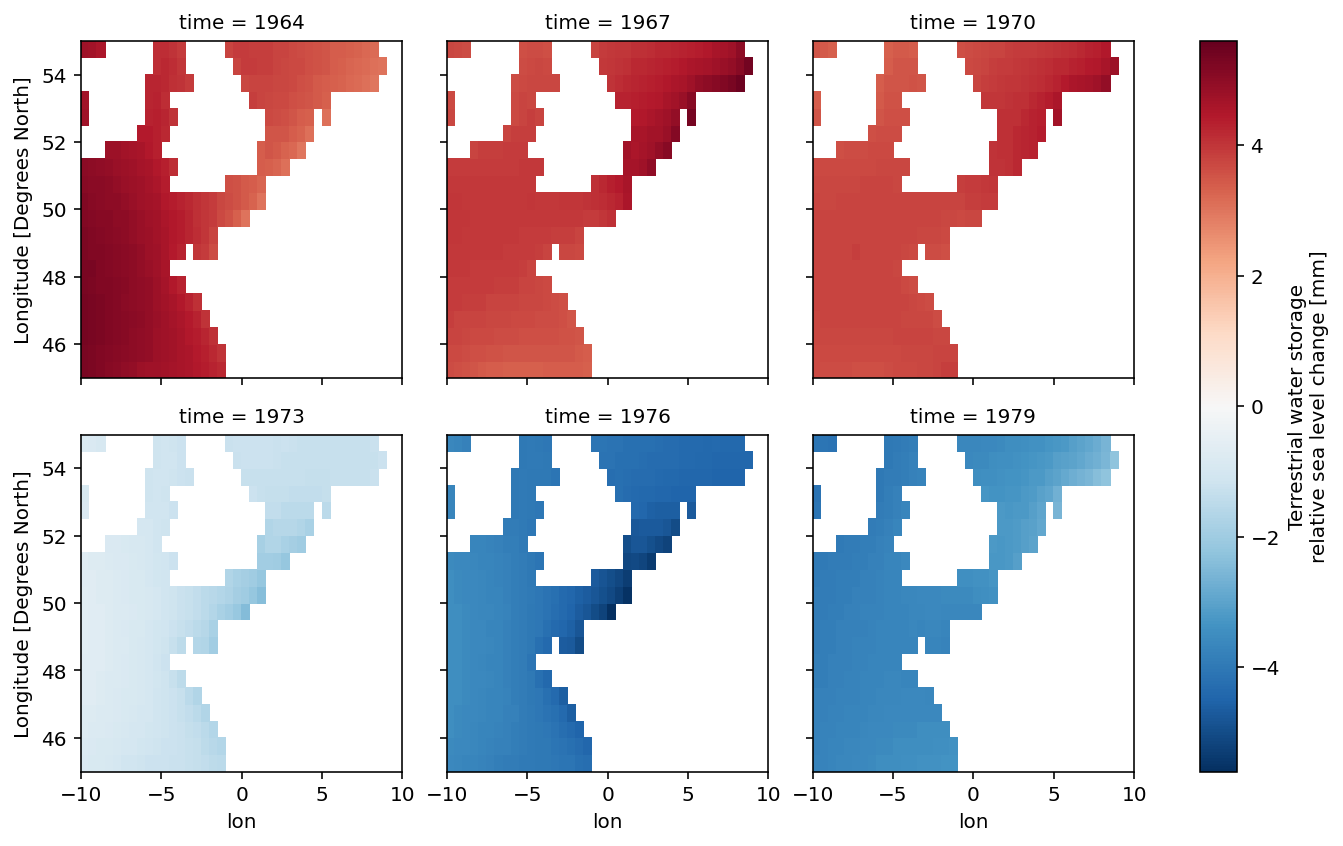

In [112]:
tws_sel = tws_ds.tws_rsl_mean.sel(time=slice(1964,1980,3) , lon=slice(-10,10), lat=slice(45,55))
tws_sel.plot(x='lon', y='lat', col='time', col_wrap=3)

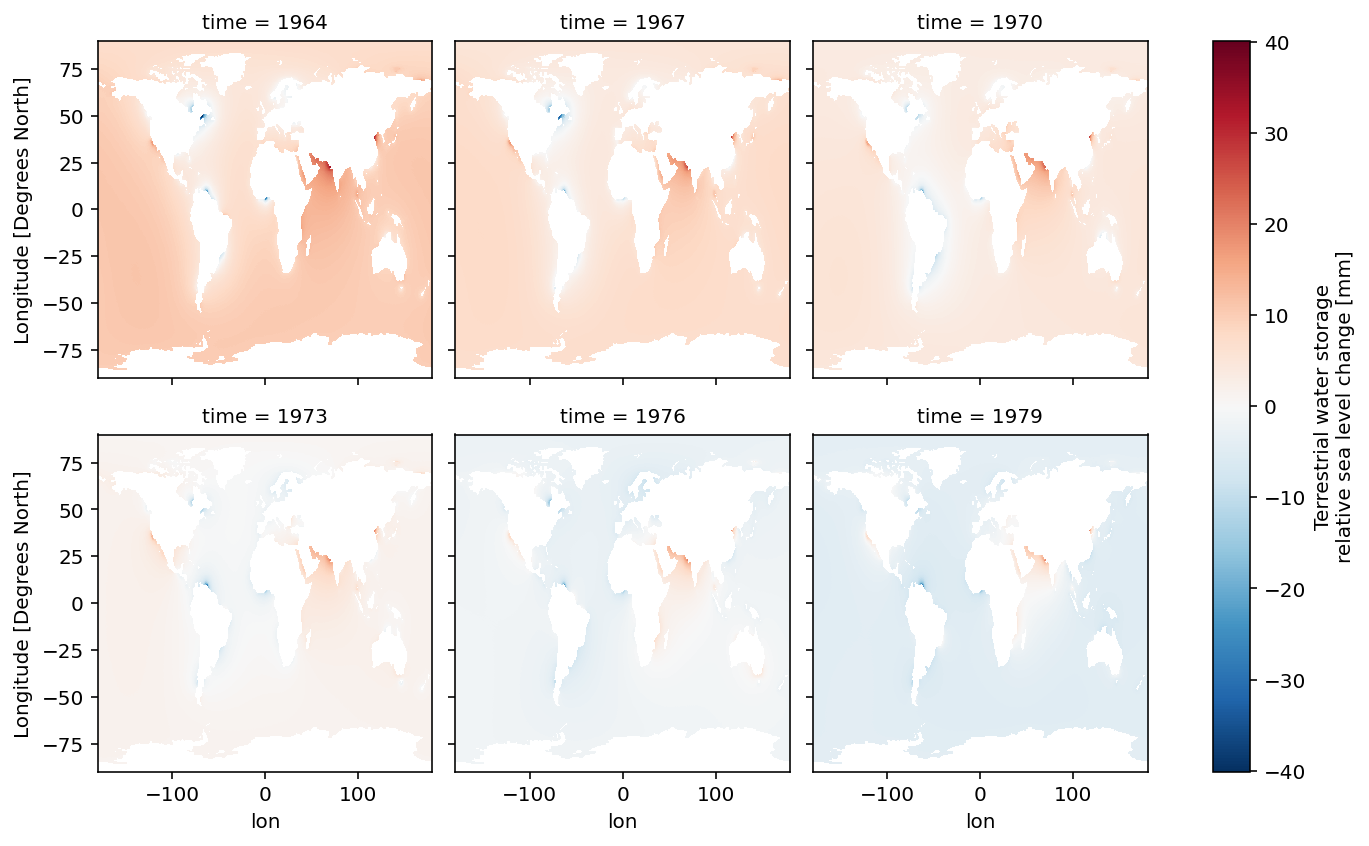

In [111]:
tws_sel = tws_ds.tws_rsl_mean.sel(time=slice(1964,1980,3))
tws_sel.plot(x='lon', y='lat', col='time', col_wrap=3)